### [E03] Cam Sticker App

# 목차
- 개요
- 루브릭 평가기준
- 학습 목표 및 참조 사항
- Project - 왕관 및 고양이 수염 스티커 적용
- Review

# 개요
- 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술 구현
- 각도 변화, 거리 변화에 반응하는 얼굴인식 카메라앱 초기버전 모델 획득

# 루브릭 평가기준
- 원본에 스티커 사진이 정상적으로 합성되었는가?
- 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었는가?
- 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였는가?

# 학습 목표 및 참조 사항
- 이미지 파일 연결 및 조정
- dlib 라이브러리 사용
- 이미지 배열의 인덱싱 예외 처리

[참조]
- image 객체 및 해당 속성 
https://kr.mathworks.com/help/matlab/creating_plots/the-image-object-and-its-properties.html
- 왜 OpenCV는 BGR 포맷을 쓸까? 
https://blog.xcoda.net/102

## Project - 카메라 스티커앱 만들기

## (1) 얼굴사진 준비

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


- 이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib 호출

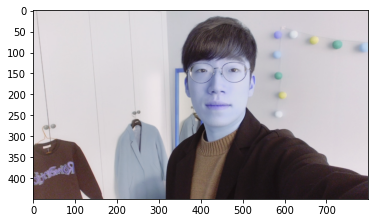

In [4]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

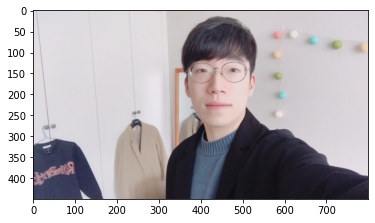

In [5]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

- opencv로 이미지 호출 후 RGB로 색상 보정

## (2) 얼굴 검출 face detection

Object detection 기술을 이용해서 얼굴의 위치를 찾겠습니다. 이번 시간에는 빠르게 만들기 위해 학습 없이 공개되어 있는 패키지를 사용하겠습니다.

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾습니다.

HOG는 이미지에서 색상의 변화량을 나타낸 것입니다. 딥러닝이 나오기 이전에 다양하게 사용되던 방식인데요. 이미지에서 단순히 색상값만 가지고 할 수 있는 일이 제한적이었기 때문에 색상의 변화량을 계산한 HOG는 굉장히 큰 도움이 되었습니다. 이미지로부터 물체의 특징만 잘 잡아내는 능력을 갖출 수 있었거든요. 2000년대 초반에도 얼굴을 인식해 카메라 초점을 잡는 기능 등에는 모두 이 방식이 응용되었습니다.

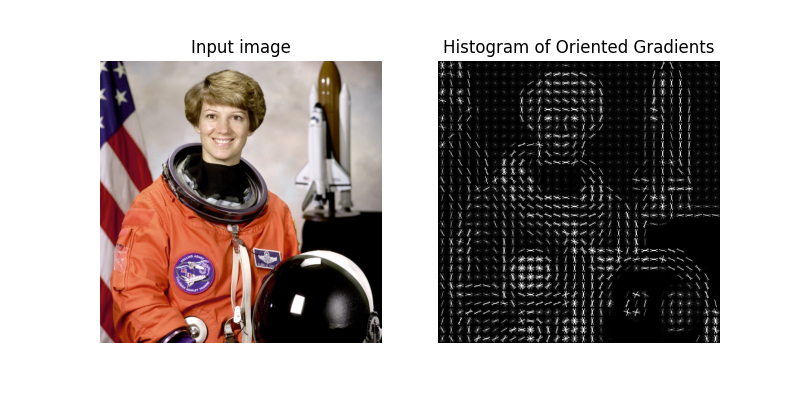
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

HOG를 시각화한 이미지에서 사람의 형체가 잘 보이시나요?

SVM은 선형 분류기입니다. 한 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터가 될텐데요. 이 여러 벡터를 잘 구분짓는 방법입니다. 여기서는 얼굴이냐 아니냐를 구분하는 것이 중요하겠죠.

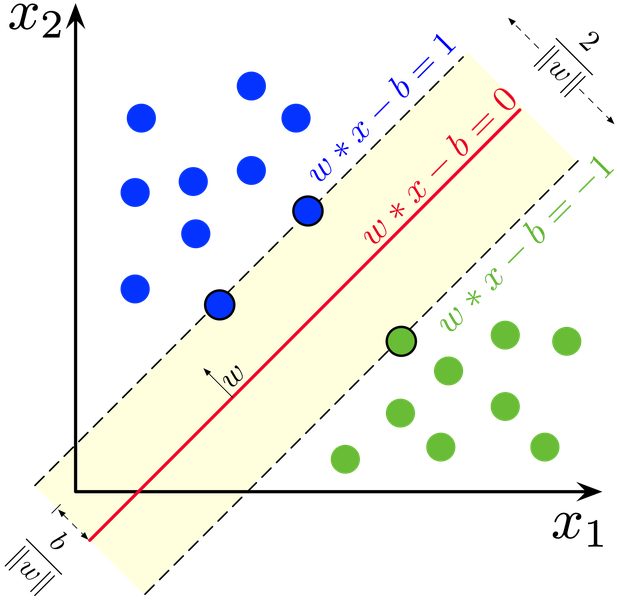
https://en.wikipedia.org/wiki/Support-vector_machine

이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못합니다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동합니다.

그렇다면 얼굴의 위치는 어떻게 찾을 수 있을까요? 바로 sliding window를 사용합니다. sliding window는 작은 영역(window)을 이동해가며 확인하는 방법을 말합니다. 큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식이겠네요. 물론 이렇게 한다면 이미지가 크면 클수록 오래걸리는 단점이 있습니다. 바로 이 지점이 딥러닝이 필요해지는 이유이기도 하지요.

In [6]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


- HOG Detector 선언 및 이미지 피라미드수 지정

rectangles[[(345, 98) (531, 284)]]


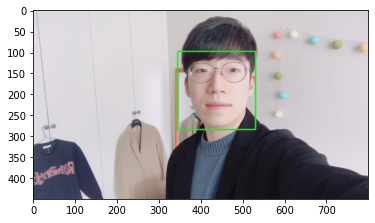

In [8]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 이미지 처리, 선형대수 뿐만 아니라 다양한 머신러닝 알고리즘을 활용할 수 있는 dlib 라이브러리로 얼굴 검출
- [참고] https://hayunjong83.tistory.com/38

## (3) 얼굴 랜드마크 face landmark

앞서 말씀 드린 것처럼 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.

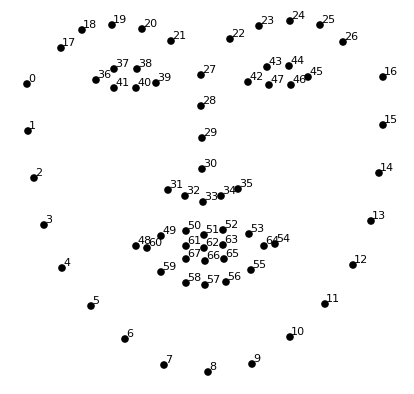
[Dlib에 사용 되는 랜드마크 순서]
이 때 점의 개수는 데이터셋과 논문마다 다릅니다. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용합니다.


In [9]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [10]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.
- face landmark 좌표 할당을 위한 lambda 함수 적용
- [참고] https://namu.wiki/w/%EB%9E%8C%EB%8B%A4%EC%8B%9D

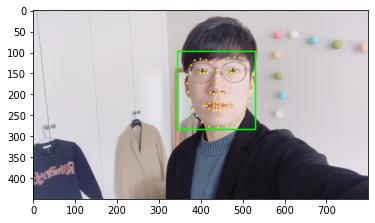

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 얼굴 랜드마크 출력

## (4) 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었습니다.

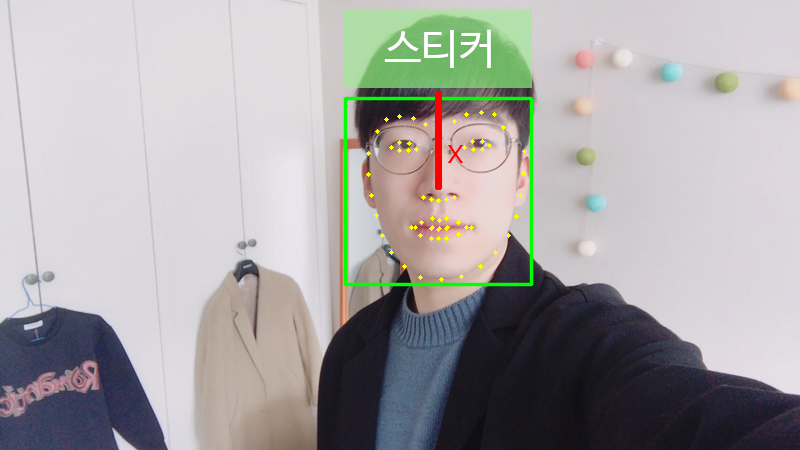

랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.


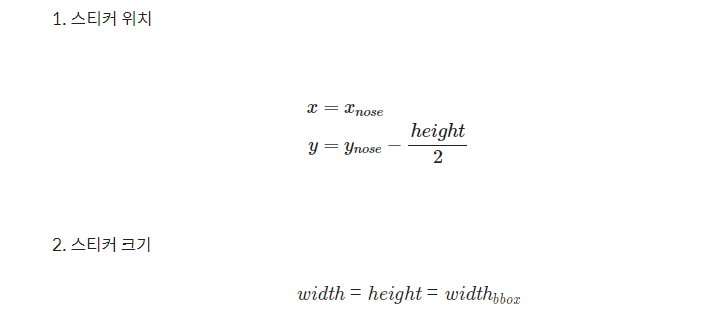

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [13]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [14]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,-98)


- 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표 및 음수값 조정

## (5) 프로젝트: 고양이 수염 스티커 만들기

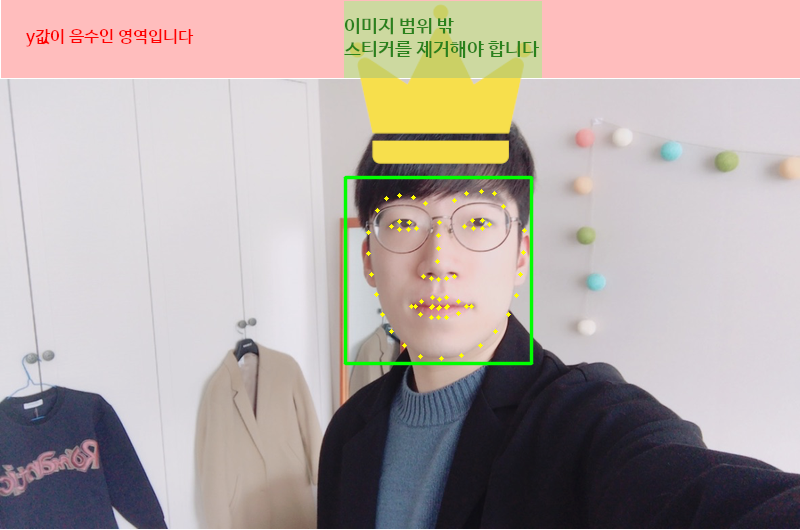

스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현됩니다. 그런데 opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

위의 경우에서는 y축 좌표의 값만 음수로 나왔지만 x축 좌표의 값도 음수로 나올 수 있겠죠?

사실 스티커가 원본 이미지의 범위를 넘어가는 경우는 하나 더 있습니다. 바로 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우입니다. 스티커 사진의 오른쪽이나 아래쪽으로 넘어가는 경우죠. 이 경우는 어떻게 처리해야 하는지 생각해보세요.

In [15]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,0)


In [16]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


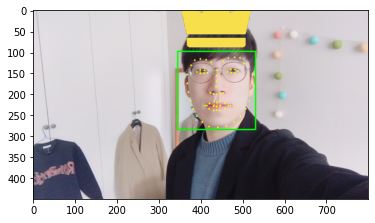

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

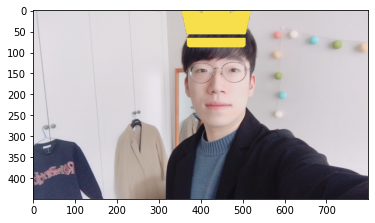

In [23]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- bounding box와 landmark를 제거하고 최종 결과만 출력

## (6) 프로젝트: 고양이 수염 스티커 만들기

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


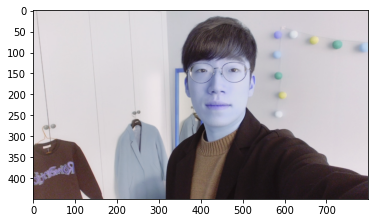

In [25]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

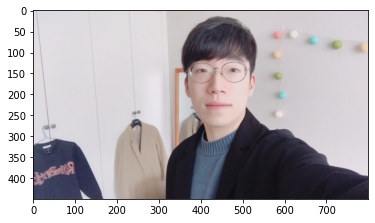

In [26]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

- 상단 프로세스와 동일한 순서로 이미지 불러오기 실행

rectangles[[(345, 98) (531, 284)]]


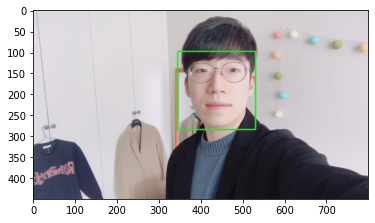

In [27]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

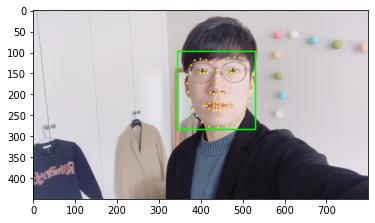

In [28]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [58]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [59]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [60]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,-98)


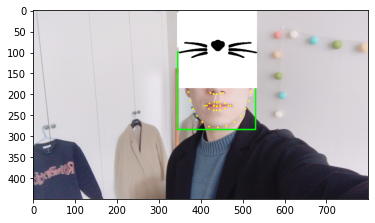

In [61]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 고양이 수염 스티커 이미지 호출 및 위치 적용

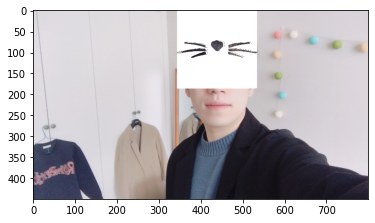

In [42]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 얼굴 검출 렉텡글 및 랜드마크 삭제

## Review

- 느낀점

In [ ]:
노드 학습 내용에 따라 쥬피터 노트북에서의 실행은 용이한 편이나 응용면에서 기초 지식 부족으로 부분적 애로사항(좌표수정 및 이미지 배경 처리)

In [ ]:
가급적 노드 진행 당일 내용의 전반적인 숙지와 질의응답을 통한 보완이 필요함을 절감(미학습 및 숙지 상태가 이후 노드에 영향)

In [ ]:
Dlib, image pyramid, refine 등 라이브러리, 함수에 대한 깊이있는 접근과 응용에 대한 개별 프로젝트성 작업 시도 기대